In [113]:
import mne
import os
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.preprocessing import read_ica
from BCOM_processing.SCRIPTS.functions import Preprocessing
from mne import compute_raw_covariance
from datahandling import BcomMEG
from wavelets import *

In [114]:
empty_room = mne.io.read_raw_fif(
    "/Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_26/3/empty_room_cleaned_ICA_raw.fif",
    preload=True
    )
empty_room.info['bads']
bad_loc_channel = "MEG 173"
empty_room.interpolate_bads(exclude=[bad_loc_channel], origin=(0., 0., 0.))



Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_26/3/empty_room_cleaned_ICA_raw.fif...
Isotrak not found
    Range : 0 ... 89999 =      0.000 ...   179.998 secs
Ready.
Reading 0 ... 89999  =      0.000 ...   179.998 secs...
Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Computing dot products for 246 MEG channels...
    Computing cross products for 246 → 1 MEG channel...
    Preparing the mapping matrix...
    Truncating at 88/246 components to omit less than 0.0001 (9.7e-05)


<Raw | empty_room_cleaned_ICA_raw.fif, 280 x 90000 (180.0 s), ~192.5 MB, data loaded>

In [115]:
noise_cov = compute_raw_covariance(empty_room, 
                                   method='auto',
                                   rank=None, 
                                   picks="meg")

Using up to 900 segments
Using data from preloaded Raw for 900 events and 100 original time points ...
0 bad epochs dropped
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 247 -> 246
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 90000
log-likelihood on unseen data (descending order):
   shrunk: -1364.518
   diagonal_fixed: -1380.199
   empirical: -1439.466
selecting best estimator: shrunk
[done]


In [116]:
print(noise_cov)
import numpy as np
print("Max:", np.max(noise_cov.data))
print("Min:", np.min(noise_cov.data))
print("Mean:", np.mean(noise_cov.data))
print("Non-zero entries:", np.count_nonzero(noise_cov.data))
print("Total number of entries", noise_cov.data.shape[0]*noise_cov.data.shape[1])

<Covariance | kind : full, shape : (247, 247), range : [-3.2e-26, +5.9e-26], n_samples : 89999>
Max: 5.86716053780229e-26
Min: -3.1822205959316634e-26
Mean: 1.6010239739048128e-27
Non-zero entries: 61009
Total number of entries 61009


Computing rank from covariance with rank=None
    Using tolerance 7e-14 (2.2e-16 eps * 247 dim * 1.3  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 247 data channels with 0 projectors


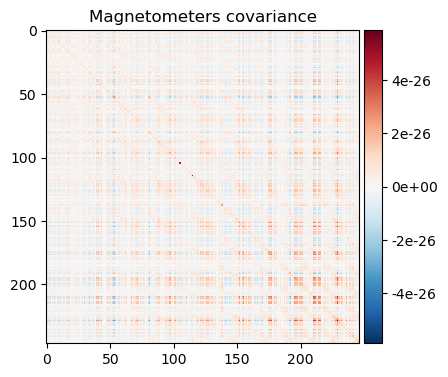

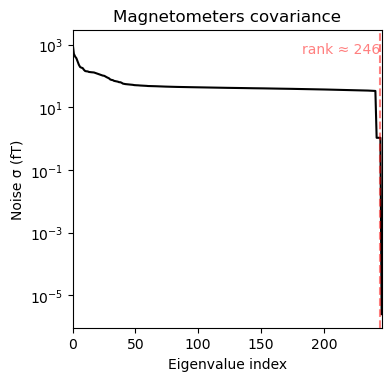

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [117]:
mne.viz.plot_cov(noise_cov, empty_room.info)

In [138]:
data_covar = mne.read_epochs(
    "/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_01_2_a_112-epo.fif",
    preload=True
    )


Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_01_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated


In [139]:
noise_cov = mne.compute_covariance(data_covar, 
                                   method='auto',
                                   rank=None,
                                   )

Reducing data rank from 247 -> 247
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 3374
log-likelihood on unseen data (descending order):
   shrunk: -1387.761
   diagonal_fixed: -1425.135
   empirical: -1426.347
selecting best estimator: shrunk
[done]


Computing rank from covariance with rank=None
    Using tolerance 2.7e-13 (2.2e-16 eps * 247 dim * 5  max singular value)
    Estimated rank (mag): 247
    MAG: rank 247 computed from 247 data channels with 0 projectors


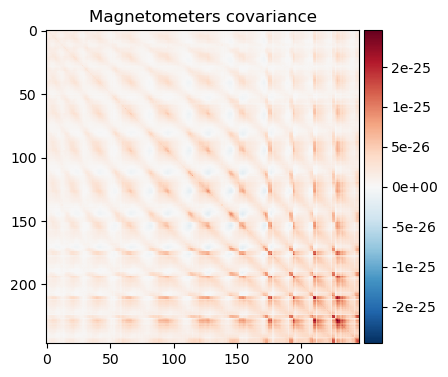

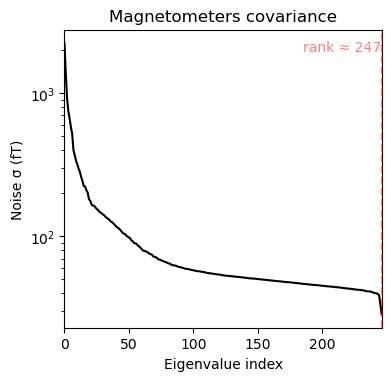

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [140]:
mne.viz.plot_cov(noise_cov, data_covar.info)

## Reconstruction

In [269]:
scaled = "scaled_fsaverage"
subject = "BCOM_18_2"

In [270]:
morphed_bem = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-5120-5120-5120-bem-sol.fif"
morphed_source = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-ico-5-src.fif"
morphed_trans = f"/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/{subject}-trans.fif"


fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

0 files missing from root.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage


In [271]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
subjects = [subject]
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=True)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_16-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_me_34-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_sa_52-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
13 matching events found
No baseline correcti

In [306]:
evoked_reading = data.data[subject]['sa_52']
print(evoked_reading)

for syllable, epochs in data.data[subject].items():
    if syllable != "sa_52":
        evoked_reading = mne.concatenate_epochs((evoked_reading, epochs))

# evoked_reading = evoked_reading.copy().apply_baseline((-0.2,0)).average()
evoked_reading.info['bads'].append("MEG 059")
evoked_reading=evoked_reading.copy().average()

<EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
 '52': 13>
Not setting metadata
25 matching events found
No baseline correction applied
Not setting metadata
37 matching events found
No baseline correction applied
Not setting metadata
51 matching events found
No baseline correction applied
Not setting metadata
58 matching events found
No baseline correction applied
Not setting metadata
75 matching events found
No baseline correction applied
Not setting metadata
81 matching events found
No baseline correction applied
Not setting metadata
91 matching events found
No baseline correction applied
Not setting metadata
103 matching events found
No baseline correction applied
Not setting metadata
108 matching events found
No baseline correction applied
Not setting metadata
122 matching events found
No baseline correction applied
Not setting metadata
128 matching events found
No baseline correction applied
Not setting metadata
146 matching events found
No ba

No projector specified for this dataset. Please consider the method self.add_proj.


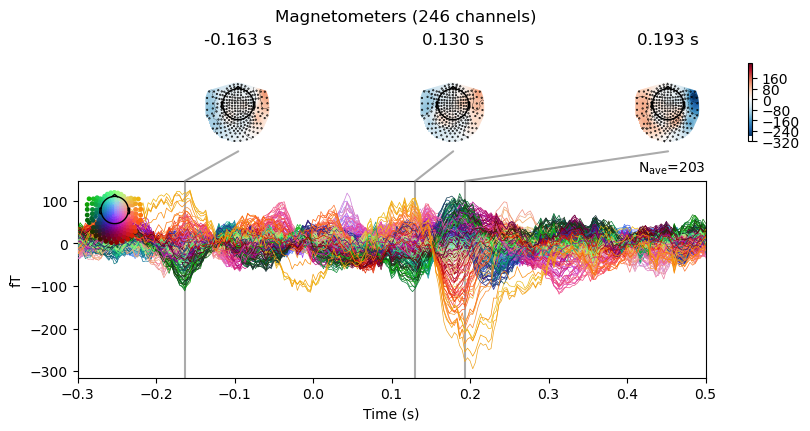

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 6.2e-12 (2.2e-16 eps * 246 dim * 1.1e+02  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 246 (0 small eigenvalues omitted)


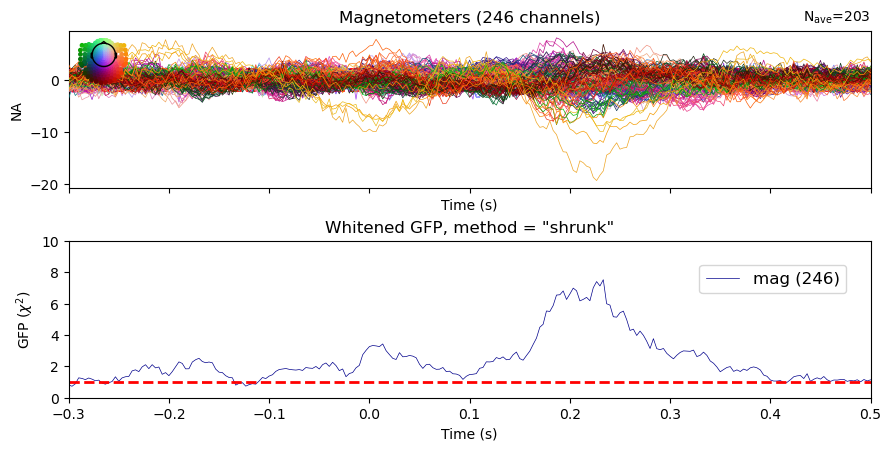

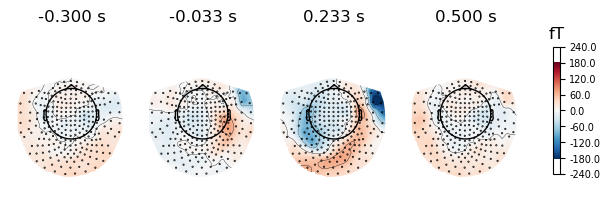

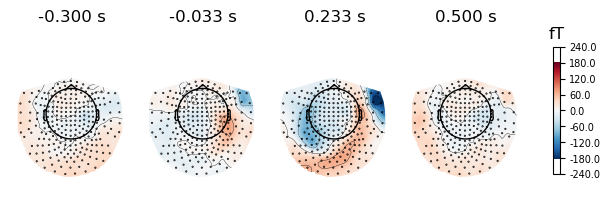

In [307]:
evoked_reading.plot_joint()
evoked_reading.plot_white(noise_cov)
evoked_reading.plot_topomap(ch_type="mag")

In [308]:
fwd = mne.make_forward_solution(
    evoked_reading.info,
    trans=morphed_trans,
    src=morphed_source, 
    bem=morphed_bem, 
    meg=True, 
    eeg=False
    )

Source space          : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_18_2/bem/scaled_fsaverage_BCOM_18_2-ico-5-src.fif
MRI -> head transform : /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/BCOM_18_2-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_18_2/bem/scaled_fsaverage_BCOM_18_2-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_18_2/bem/scaled_fsaverage_BCOM_18_2-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999487 0.000643 -0.032008      -3.32 mm
    -0.001029 0.999927 -0.012061      25.53 mm
    0.031997 0.012088 0.999415      35.90 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil 

In [309]:
#create inverse operator
inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked_reading.info, 
    fwd, 
    noise_cov, 
    loose=0.2, #surface so this is equivalent to auto - weights the source variances of the dipole components parallel to cortical surface, 
    depth=0.8, #actually this is ignored for eLoreta; but determines the weight of the forward using depth prior
)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 246 channels.
    246 out of 247 channels remain after picking
Selected 246 channels
Creating the depth weighting matrix...
    246 magnetometer or axial gradiometer channels
    limit = 20345/20484 = 10.013201
    scale = 3.44174e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 6.2e-12 (2.2e-16 eps * 246 dim * 1.1e+02  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the

In [310]:
# applt inverse operator for all of the epochs
snr = 3.0 # idea that the signal is pretty noisy
lambda2 = 1.0/snr**2 # regularization parameter

stc = mne.minimum_norm.apply_inverse(
    evoked_reading,
    inverse_operator=inverse_operator,
    lambda2=lambda2,
    method='dSPM'
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 203
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 246 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.06 × 52 + 0.06 × 16 + 0.06 × 34 + 0.07 × 42 + 0.03 × 24 + 0.08 × 12 + 0.03 × 56 + 0.05 × 36 + 0.06 × 14 + 0.02 × 54 + 0.07 × 26 + 0.03 × 66 + 0.09 × 32 + 0.04 × 44 + 0.06 × 46 + 0.05 × 62 + 0.05 × 64 + 0.07 × 22"...
    Picked 246 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  85.0% variance
    Combining the current components...
    dSPM...
[done]


In [333]:
brain = stc.plot(hemi='both')
brain.add_label(label=label, borders=True, color='red')

Using control points [ 4.70014797  5.49627016 12.16364199]


## Morph back to FSAverage for labels to match

In [312]:
morph = mne.compute_source_morph(
    src=inverse_operator['src'],
    subject_from=f"{scaled}_{subject}",#morphedfsaveragefoldername, i.e., fsaverage_scaled xxx 
    subject_to='fsaverage',
    # subjects_dir=,#saving directory?
)

morphed_stc = morph.apply(stc)

surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    2 smooth iterations done.
    2 smooth iterations done.
[done]
[done]


In [313]:
morphed_stc.plot(hemi='split')

Using control points [ 4.70014797  5.49627016 12.16364199]


In [320]:
# read labels from fsaverage annotation using aparc parcellation
labels = mne.read_labels_from_annot(
    subject='fsaverage', 
    parc='aparc.a2009s', 
    hemi='lh',
    subjects_dir=subjects_dir)
labels


Reading labels from parcellation...
   read 75 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.a2009s.annot


[<Label | fsaverage, 'G_Ins_lg_and_S_cent_ins-lh', lh : 769 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Ant-lh', lh : 2171 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Ant-lh', lh : 1957 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Post-lh', lh : 2386 vertices>,
 <Label | fsaverage, 'G_and_S_frontomargin-lh', lh : 932 vertices>,
 <Label | fsaverage, 'G_and_S_occipital_inf-lh', lh : 1277 vertices>,
 <Label | fsaverage, 'G_and_S_paracentral-lh', lh : 2272 vertices>,
 <Label | fsaverage, 'G_and_S_subcentral-lh', lh : 2607 vertices>,
 <Label | fsaverage, 'G_and_S_transv_frontopol-lh', lh : 627 vertices>,
 <Label | fsaverage, 'G_cingul-Post-dorsal-lh', lh : 1098 vertices>,
 <Label | fsaverage, 'G_cingul-Post-ventral-lh', lh : 520 vertices>,
 <Label | fsaverage, 'G_cuneus-lh', lh : 1430 vertices>,
 <Label | fsaverage, 'G_front_inf-Opercular-lh', lh : 1800 vertices>,
 <Label | fsaverage, 'G_front_inf-Orbital-lh', lh : 453 vertices>,
 <Label | fsaverage, 'G_front_inf-Triangul

In [332]:
label = [label for label in labels if 'G_occipital_middle-lh' in label.name][0]
label

<Label | fsaverage, 'G_occipital_middle-lh', lh : 2098 vertices>

In [336]:
src = mne.read_source_spaces("/Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif")
label_time_courses = mne.extract_label_time_course(
    morphed_stc,
    label,
    src=src,
    mode='mean_flip',
    return_generator=False,
)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Extracting time courses for 1 labels (mode: mean_flip)


In [384]:
import pywt
sampling_rate = 300 # data already downsampled to 300 at this point
log_samples = 100 # we want 100 coefficients
cwt_wavelet_name = 'cmor' # reconstruction wavelet
B = 1.0 # wavelet bandwith (higher means more frequencies at each scale, but less precision in peak timing)
C = 1.0 # central frequency (higher means more oscialltions per time window, meaning higher frequency features per scale)
cwt_wavelet = f'{cwt_wavelet_name}{B}-{C}'
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
sampling_period = 1/sampling_rate
scales = pywt.central_frequency(wavelet=cwt_wavelet)/ (frequencies * sampling_period)
dwt_wavelet_name='db4' # denoizing wavelet 
level=5 # level of decomposition. NB in Dash et al. they use 7, but our signal is shorter, so 5 is max
x = process_channel(
                    signal=label_time_courses,
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                    )

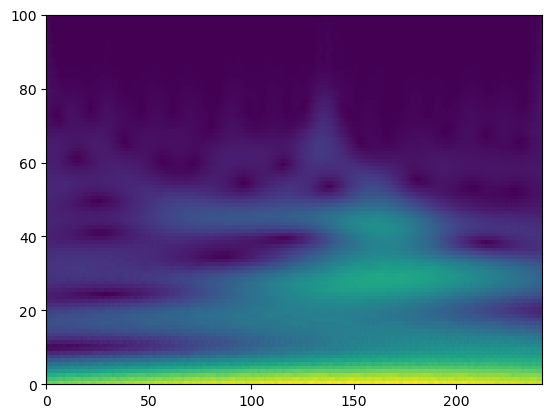

In [385]:
# Reshape x to a 2D array with shape (-1, x.shape[-1]) (flatten all but the last dimension)
x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
x = x.squeeze()
plt.pcolormesh(x)

In [101]:
x = mne.read_epochs(fname="/Volumes/BCOM-1/ciprian_project/data_analyzed/normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_a_12-epo.fif", preload=True)

Reading /Volumes/BCOM-1/ciprian_project/data_analyzed/normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_a_12-epo.fif ...


    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated


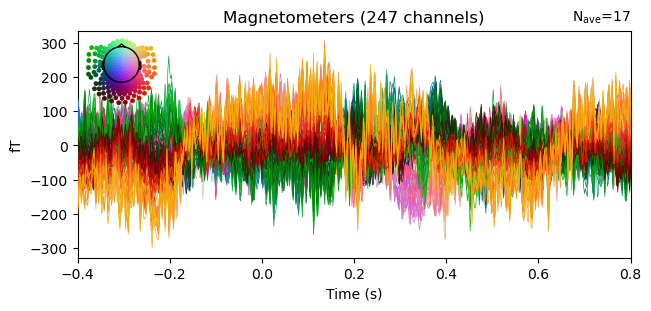

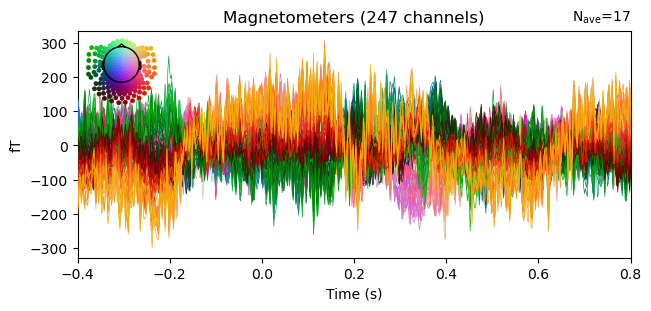

In [110]:
x.average().plot()

In [102]:
y = mne.read_epochs(fname="/Volumes/BCOM/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_01_2_a_12-epo.fif")

Reading /Volumes/BCOM/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_01_2_a_12-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated


In [104]:
y.plot()

Using pyopengl with version 3.1.6


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [55]:
z = mne.io.read_raw_fif(fname="/Volumes/BCOM-1/ciprian_project/data_analyzed/preprocessed/BCOM_01/2/subject_cleaned_ica_raw.fif", preload=True)

Opening raw data file /Volumes/BCOM-1/ciprian_project/data_analyzed/preprocessed/BCOM_01/2/subject_cleaned_ica_raw.fif...
    Range : 0 ... 378957 =      0.000 ...   757.914 secs
Ready.
Reading 0 ... 378957  =      0.000 ...   757.914 secs...


In [56]:
z = z.interpolate_bads(exclude=["MEG 173"])

Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 88.2 mm
    Computing dot products for 244 MEG channels...
    Computing cross products for 244 → 3 MEG channels...
    Preparing the mapping matrix...
    Truncating at 62/244 components to omit less than 0.0001 (9.4e-05)


In [89]:
include_idx_exc = mne.pick_channels(z.ch_names, include=[], exclude=["MEG 173"])

In [91]:
include_idx_exc

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [92]:
include_idx = mne.pick_channels(z.ch_names, include=[], exclude=[])

In [70]:
z._data.shape

(284, 378958)

In [72]:
from mne.baseline import rescale

# Rescale the data using the baseline period (0, 0.5)
rescaled = rescale(z._data[include_idx], times=z.times, baseline=(0, 0.5))

Applying baseline correction (mode: mean)


In [73]:
rescaled.shape

(283, 378958)

In [75]:
z[include_idx] = rescaled

In [94]:
z._data.shape

(284, 378958)